In [10]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from matplotlib.ticker import  MultipleLocator, FormatStrFormatter
import pandas as pd 
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms, datasets
import re
import math
import ast

# Data loading
## Train dataset

In [34]:
data_train = pd.read_csv('train.csv')
data_train.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


## Test dataset

In [35]:
data_test = pd.read_csv('test.csv')
data_test.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,T1,B,NaN,15.0,20000542,1408039037,A,False,"[[-8.585676,41.148522],[-8.585712,41.148639],[..."
1,T2,B,NaN,57.0,20000108,1408038611,A,False,"[[-8.610876,41.14557],[-8.610858,41.145579],[-..."
2,T3,B,NaN,15.0,20000370,1408038568,A,False,"[[-8.585739,41.148558],[-8.58573,41.148828],[-..."
3,T4,B,NaN,53.0,20000492,1408039090,A,False,"[[-8.613963,41.141169],[-8.614125,41.141124],[..."
4,T5,B,NaN,18.0,20000621,1408039177,A,False,"[[-8.619903,41.148036],[-8.619894,41.148036]]"


# New features and statistics
## New features

In [38]:
data_test['TIMESTAMP'] = data_test['TIMESTAMP'].astype('datetime64[s]')
datetime_index = pd.DatetimeIndex(data_test['TIMESTAMP'])
data_test['WEEK_OF_YEAR'] = datetime_index.weekofyear - 1
data_test['DAY_OF_WEEK'] = datetime_index.dayofweek
data_test['QUARTER_HOUR'] = datetime_index.hour * 4 + datetime_index.minute // 15

data_train['TIMESTAMP'] = data_train['TIMESTAMP'].astype('datetime64[s]')
datetime_index = pd.DatetimeIndex(data_train['TIMESTAMP'])
data_train['WEEK_OF_YEAR'] = datetime_index.weekofyear - 1
data_train['DAY_OF_WEEK'] = datetime_index.dayofweek
data_train['QUARTER_HOUR'] = datetime_index.hour * 4 + datetime_index.minute // 15


data_test.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,WEEK_OF_YEAR,DAY_OF_WEEK,QUARTER_HOUR
0,T1,B,NaN,15.0,20000542,2014-08-14 17:57:17,A,False,"[[-8.585676,41.148522],[-8.585712,41.148639],[...",32,3,71
1,T2,B,NaN,57.0,20000108,2014-08-14 17:50:11,A,False,"[[-8.610876,41.14557],[-8.610858,41.145579],[-...",32,3,71
2,T3,B,NaN,15.0,20000370,2014-08-14 17:49:28,A,False,"[[-8.585739,41.148558],[-8.58573,41.148828],[-...",32,3,71
3,T4,B,NaN,53.0,20000492,2014-08-14 17:58:10,A,False,"[[-8.613963,41.141169],[-8.614125,41.141124],[...",32,3,71
4,T5,B,NaN,18.0,20000621,2014-08-14 17:59:37,A,False,"[[-8.619903,41.148036],[-8.619894,41.148036]]",32,3,71


## Week of the year

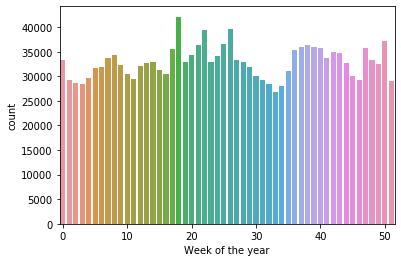

In [14]:
plt.figure()
sns.countplot(data_train['WEEK_OF_YEAR'])
plt.gca().xaxis.set_major_locator(MultipleLocator(10))
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))
plt.xlabel('Week of the year')
plt.show()

## Day of the week

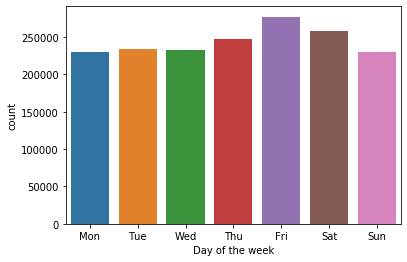

In [15]:
plt.figure()
sns.countplot(data_train['DAY_OF_WEEK'])
plt.gca().set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('Day of the week')
plt.show()

## Quarter hour of the day

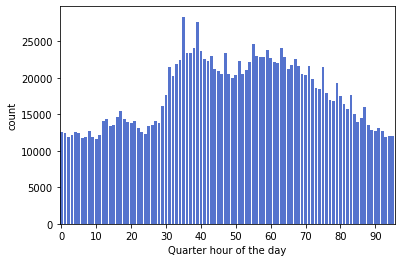

In [16]:
plt.figure()
sns.countplot(data_train['QUARTER_HOUR'], color='royalblue')
plt.gca().xaxis.set_major_locator(MultipleLocator(10))
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))
plt.xlabel('Quarter hour of the day')
plt.show()

## Trip duration

In [40]:
data_train['DURATION'] = data_train['POLYLINE'].apply(lambda x: 15 * len(x.split(","))/2)
data_test['DURATION'] = data_test['POLYLINE'].apply(lambda x: 15 * len(x.split(","))/2)

data_test.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,WEEK_OF_YEAR,DAY_OF_WEEK,QUARTER_HOUR,DURATION
0,T1,B,NaN,15.0,20000542,2014-08-14 17:57:17,A,False,"[[-8.585676,41.148522],[-8.585712,41.148639],[...",32,3,71,165.0
1,T2,B,NaN,57.0,20000108,2014-08-14 17:50:11,A,False,"[[-8.610876,41.14557],[-8.610858,41.145579],[-...",32,3,71,600.0
2,T3,B,NaN,15.0,20000370,2014-08-14 17:49:28,A,False,"[[-8.585739,41.148558],[-8.58573,41.148828],[-...",32,3,71,600.0
3,T4,B,NaN,53.0,20000492,2014-08-14 17:58:10,A,False,"[[-8.613963,41.141169],[-8.614125,41.141124],[...",32,3,71,120.0
4,T5,B,NaN,18.0,20000621,2014-08-14 17:59:37,A,False,"[[-8.619903,41.148036],[-8.619894,41.148036]]",32,3,71,30.0


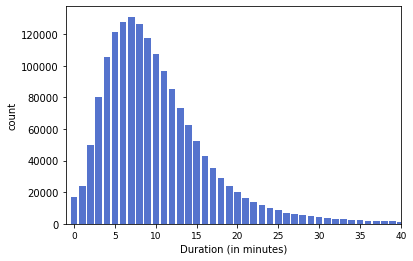

In [18]:
plt.figure()
bins = np.arange(60, data_train.DURATION.max(), 60)
binned = pd.cut(data_train.DURATION, bins, labels=bins[:-1]/60, include_lowest=True)
sns.countplot(binned, color='royalblue')
plt.gca().xaxis.set_major_locator(MultipleLocator(5))
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))
plt.xlim(-1, 40)
plt.xticks(fontsize=9)
plt.xlabel('Duration (in minutes)')
plt.show()

## Trip flying distance

In [19]:
def equi_rec_loss (pos1,pos2):
    R = 6371
    long1, lat1 = pos1
    long2, lat2 = pos2
    
    long1 = long1*np.pi/180
    long2 = long2*np.pi/180
    lat1 = lat1*np.pi/180
    lat2 = lat2*np.pi/180
    
    d = ( (long1-long2) * np.cos((lat1-lat2)/2) )**2 + (lat1-lat2)**2
    return R*np.sqrt(d)

In [41]:
def flying_distance(x):
    x = x.replace("[","")
    x = x.replace("]","")
    x = x.split(",")
    if (len(x) == 1):
        return 0
    l = len(x)
    pos1 = [float(x[0]),float(x[1])]
    pos2 = [float(x[l-2]),float(x[l-1])]
    dist = equi_rec_loss(pos1,pos2)
    return dist

data_train['FLYING_DISTANCE'] = data_train['POLYLINE'].apply(flying_distance)
data_test['FLYING_DISTANCE'] = data_test['POLYLINE'].apply(flying_distance)
data_test.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,WEEK_OF_YEAR,DAY_OF_WEEK,QUARTER_HOUR,DURATION,FLYING_DISTANCE
0,T1,B,NaN,15.0,20000542,2014-08-14 17:57:17,A,False,"[[-8.585676,41.148522],[-8.585712,41.148639],[...",32,3,71,165.0,0.228788
1,T2,B,NaN,57.0,20000108,2014-08-14 17:50:11,A,False,"[[-8.610876,41.14557],[-8.610858,41.145579],[-...",32,3,71,600.0,2.239547
2,T3,B,NaN,15.0,20000370,2014-08-14 17:49:28,A,False,"[[-8.585739,41.148558],[-8.58573,41.148828],[-...",32,3,71,600.0,2.447710
3,T4,B,NaN,53.0,20000492,2014-08-14 17:58:10,A,False,"[[-8.613963,41.141169],[-8.614125,41.141124],[...",32,3,71,120.0,0.077943
4,T5,B,NaN,18.0,20000621,2014-08-14 17:59:37,A,False,"[[-8.619903,41.148036],[-8.619894,41.148036]]",32,3,71,30.0,0.001001


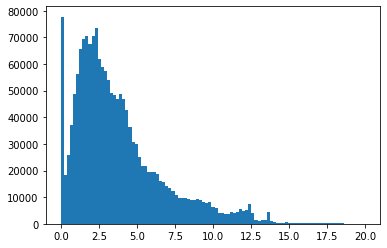

In [21]:
plt.hist(data_train.FLYING_DISTANCE,bins = np.linspace(0, 20, 100))
plt.show()

# Data cleaning

In [52]:
#On enlève les features trip id, day type, CALL TYPE, MISSING TYPE, duration
data_train_2=data_train.drop('TRIP_ID',axis=1)
data_train_2=data_train_2.drop('CALL_TYPE',axis=1)
data_train_2=data_train_2.drop('DAY_TYPE',axis=1)
data_train_2=data_train_2.drop('MISSING_DATA',axis=1)
data_train_2=data_train_2.fillna(-1)

data_test_2=data_test.drop('TRIP_ID',axis=1)
data_test_2=data_test_2.drop('CALL_TYPE',axis=1)
data_test_2=data_test_2.drop('DAY_TYPE',axis=1)
data_test_2=data_test_2.drop('MISSING_DATA',axis=1)
data_test_2=data_test_2.fillna(-1)

# Data correlation

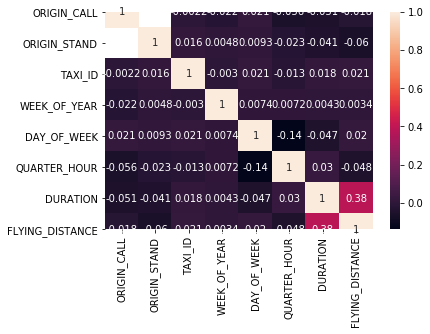

In [24]:
matrix_corr=data_train_2.corr()
sns.heatmap(matrix_corr, annot=True)


# Data preprocessing : truncate polyline

In [45]:
def get_last(poly):
    if len(poly)>3:
        liste=poly.split(',')
        elmt1=float(liste[-1].replace(']','').replace('[',''))
        elmt2=float(liste[-2].replace(']','').replace('[',''))
        l=[elmt2,elmt1]
    else:
        l=[]
    return(l)
    

In [70]:
data_test_3=data_test_2.copy()
data_train_3=data_train_2.copy()

def random_truncate(coords):
    """
    Randomly truncate the end of the trip's polyline points to simulate partial trips.
    This is only intended to be used for our custom train/validation/test datasets
    and not for the final test dataset provided by the competition as that one is
    already partial.
    """
    coords=ast.literal_eval(coords)
    # There's no need to truncate if there's not more than one item
    if len(coords) <= 1:
        return coords
    
    # Pick a random number of items to be removed from the list.
    # (We do "-1" to ensure we have at least one item left)
    n = np.random.randint(len(coords)-1)

    if n > 0:
        # Return the list without its last n items
        return coords[:-n]
    else:
        # No truncation needed in this case
        return (coords)
    
def truncate(df):
    df['POLYLINE_TRUNCATE']=df['POLYLINE'].copy()
    df['POLYLINE_TRUNCATE']=df['POLYLINE_TRUNCATE'].apply(random_truncate)
    #The labels are the last polyline coordinates, i.e. the trips' destinations.
    df['LABEL'] = df['POLYLINE'].copy()
    df['LABEL']=df['LABEL'].apply(get_last)
    return df

data_truncate_train=truncate(data_train_3)
data_truncate_test=truncate(data_test_3)

# Data saving

In [153]:
data_truncate_train=data_truncate_train.fillna('-1').drop(data_truncate_train.columns[0],axis=1)
data_truncate_train.to_csv('data_truncate_train_label.csv')

In [154]:
data_truncate_test=data_truncate_test.fillna('-1').drop(data_truncate_test.columns[0],axis=1)
data_truncate_test.to_csv('data_truncate_test_label.csv')